In [124]:
from astropy.table import Table
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from minisom import MiniSom
import pickle

In [2]:
df_L3_info = Table.read('../dataset/L3_COSMOS2020_Richard_RefCat_2023DEC4_info.fits')
df_L3_info = df_L3_info.to_pandas()

In [4]:
L3_phot_data = np.loadtxt('../dataset/L3_COSMOS2020_Richard_RefCat_2023DEC4_averaged_phot102.txt')
phot_data = L3_phot_data[:,3::2]
phot_err_data = L3_phot_data[:,4::2]

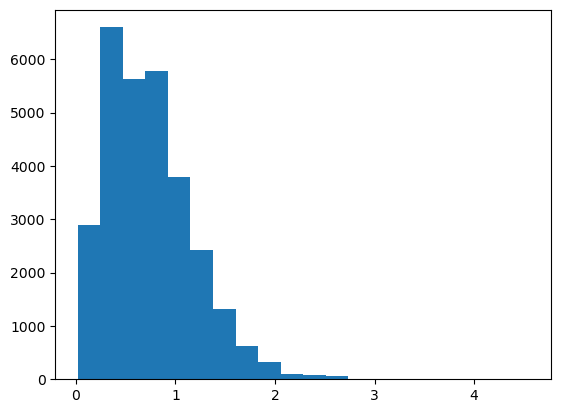

In [57]:
plt.hist(df_L3_info["z_true"], bins = 20)
plt.show()

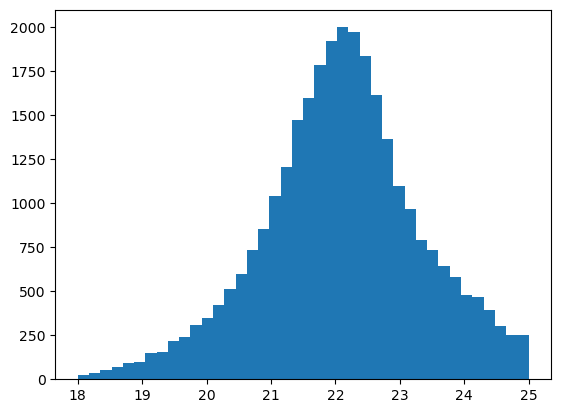

In [58]:
plt.hist(df_L3_info["HSC_i_MAG"], bins = 40)
plt.show()

In [5]:
data = (phot_data - np.mean(phot_data, axis=0)) / np.std(phot_data, axis=0)

In [80]:
def basic_som(data, dim, cmap, iteration = 1, sigma = 1, learning_rate = 1):
    som = MiniSom(dim, dim, data.shape[1], sigma = sigma, learning_rate = learning_rate)
    som.random_weights_init(data)
    som.train(data, iteration, use_epochs = True)

    print("Finish traininging SOM.")
    print("Start making diagrams...")

    density_map = np.zeros(dim ** 2).reshape(dim, dim)
    magnitude_map = np.zeros(dim ** 2).reshape(dim, dim)
    magnitude_map.fill(np.nan)
    z_map = np.zeros(dim ** 2).reshape(dim, dim)
    z_map.fill(np.nan)
    
    labels_map_1 = som.labels_map(data, [0] * len(data))
    labels_map_2 = som.labels_map(data, tuple(map(tuple, np.concatenate((np.expand_dims(df_L3_info["HSC_i_MAG"].values, axis = 1), np.expand_dims(df_L3_info["z_true"].values, axis = 1)), axis = -1))))

    for i in labels_map_1.keys():
        density_map[int(list(i)[0]), int(list(i)[1])] = labels_map_1[i][0]

    print("Finish collecting data for density map.")
    
    for i in labels_map_2.keys():
        properties = np.mean(np.array(list(labels_map_2[i].keys())), axis = 0)
        magnitude_map[int(list(i)[0]), int(list(i)[1])] = properties[0]
        z_map[int(list(i)[0]), int(list(i)[1])] = properties[1]

    print("Finish collecting data for magnitude map.")

    print(f"Topological error: {som.topographic_error(data)}")
    print(f"Quantization error: {som.quantization_error(data)}")

    %matplotlib inline
    plt.close()
    plt.figure(figsize = (25, 25))
    plt.subplot(221)
    plt.pcolor(som.distance_map().T, cmap='YlGn')  # plotting the distance map as background
    plt.colorbar()
    plt.title("Distance map (U-matrix)")

    plt.subplot(222)
    plt.pcolor(density_map.T, cmap='YlGn')
    plt.colorbar()
    plt.title("Density Map")

    plt.subplot(223)
    plt.pcolor(magnitude_map.T, cmap="plasma" + "_r")
    plt.colorbar()
    plt.title("HSC I Magnitude Map")

    plt.subplot(224)
    plt.pcolor(z_map.T, cmap="jet")
    plt.colorbar()
    plt.title("True Redshift Map")
    
    return som

In [ ]:
som = basic_som(data = data, dim = 40, cmap = "viridis", sigma = 0.4)

In [ ]:
# som = MiniSom(100, 100, data.shape[1], sigma=  1, learning_rate = 1,
#               neighborhood_function='gaussian', random_seed=10)

# max_iter = 1000
# q_error = []
# t_error = []

# for i in range(max_iter):
#     rand_i = np.random.randint(len(data))
#     som.update(data[rand_i], som.winner(data[rand_i]), i, max_iter)
#     q_error.append(som.quantization_error(data))
#     t_error.append(som.topographic_error(data))

# plt.plot(np.arange(max_iter), q_error, label='quantization error')
# plt.plot(np.arange(max_iter), t_error, label='topographic error')
# plt.ylabel('error')
# plt.xlabel('iteration index')
# plt.legend()
# plt.show()

In [129]:
b = []
for i in range(3, 11):
    dim = i * 10
    for j in range(1, i):
        sigma1 = j * 10
        sigma2 = j / 10
        for k in range(1, 11):
            rate1 = k
            rate2 = k / 10

            a = {}
            a["dim"] = dim
            a["sigma"] = sigma1
            a["rate"] = rate1
            b.append(a)

            a = {}
            a["dim"] = dim
            a["sigma"] = sigma1
            a["rate"] = rate2
            b.append(a)
            
            a = {}
            a["dim"] = dim
            a["sigma"] = sigma2
            a["rate"] = rate1
            b.append(a)
            
            a = {}
            a["dim"] = dim
            a["sigma"] = sigma2
            a["rate"] = rate2
            b.append(a)